In [1]:
import sys
sys.path.append('../')
import pickle
import re
import glob
import os

import time

import theano
import theano.tensor as T
import numpy as np
import pandas as p
import lasagne as nn

from utils import hms, architecture_string, get_img_ids_from_iter

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
!gcc --version

gcc (Ubuntu 4.8.5-4ubuntu8~16.04.1) 4.8.5
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!which nvcc

/usr/local/cuda-7.0/bin/nvcc


In [4]:
!python --version

Python 2.7.16 :: Anaconda, Inc.


In [4]:
!git clone https://github.com/Theano/Theano
%cd Theano
!git checkout 9a653e3e91c0e38b6643e4452199931e792a24a2
!pip install .
%cd ..

fatal: destination path 'Theano' already exists and is not an empty directory.
/users/avanti/kaggle_diabetic_retinopathy/notebooks/Theano
HEAD is now at 9a653e3... Merge pull request #3150 from caglar/theano_shared_zero2
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Processing /users/avanti/kaggle_diabetic_retinopathy/notebooks/Theano
  Stored in directory: /tmp/pip-ephem-wheel-cache-88DvGn/wheels/2e/80/ce/e61c44e4fc9a975b404057b2fe01224d2ea79dec59f36d64ec
Successfully built Theano
  Found existing installation: Theano 0.7.0
    Uninstalling Theano-0.7.0:
      Successfully uninstalled Theano-0.7.0
/users/avanti/kaggle_diabetic_retinopathy/notebooks


In [5]:
!git clone https://github.com/Lasagne/Lasagne
%cd Lasagne
!git checkout cf1a23c21666fc0225a05d284134b255e3613335
!pip install .
%cd ..

fatal: destination path 'Lasagne' already exists and is not an empty directory.
/users/avanti/kaggle_diabetic_retinopathy/notebooks/Lasagne
HEAD is now at cf1a23c... Merge pull request #278 from skaae/add_embedding_doc
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Processing /users/avanti/kaggle_diabetic_retinopathy/notebooks/Lasagne
  Stored in directory: /tmp/pip-ephem-wheel-cache-NQqxkB/wheels/41/17/42/bed688d24ee7c4d3f5638aa526295c91eba55d8d3aec20e9b1
Successfully built Lasagne
  Found existing installation: Lasagne 0.1.dev0
    Uninstalling Lasagne-0.1.dev0:
      Successfully uninstalled Lasagne-0.1.dev0
/users/avanti/kaggle_diabetic_retinopathy/notebooks


In [35]:
!conda list

# packages in environment at /users/avanti/anaconda3/envs/py2diabeticretinopathy:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
attrs                     19.1.0                   py27_1  
backports                 1.0                        py_2  
backports.shutil_get_terminal_size 1.0.0                    py27_2  
backports_abc             0.5                        py_0  
blas                      1.0                         mkl  
bleach                    3.1.0                    py27_0  
ca-certificates           2019.5.15                     0  
cairo                     1.12.18                       0  
certifi                   2019.6.16                py27_1  
configparser              3.7.4                    py27_0  
cycler                    0.10.0                   py27_0  
cython                    0.17                     pypi_0    pypi
dateutil                  2.4.1                    py2

In [6]:
%pylab inline

rcParams['figure.figsize'] = 16, 6

Populating the interactive namespace from numpy and matplotlib


In [7]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

First we load the dump of the trained network.

In [8]:
dump_path = '../dumps/2015_07_17_123003.pkl'

In [9]:
model_data = pickle.load(open(dump_path, 'r'))

In [10]:
# Let's set the in and output layers to some local vars.
l_out = model_data['l_out']
l_ins = model_data['l_ins']

Some info about the architecture of the model:

In [11]:
model_arch = architecture_string(model_data['l_out'])

num_params = nn.layers.count_params(l_out)
model_arch += "\nNumber of parameters: %d.\n\n" % num_params
print(model_arch)

   0  InputLayer                   (64, 3, 512, 512)  
   1  Conv2DDNNLayer               (64, 32, 256, 256)  7 //2
   2  MaxPool2DDNNLayer            (64, 32, 127, 127)  3 //2
   3  Conv2DDNNLayer               (64, 32, 127, 127)  3 //1
   4  Conv2DDNNLayer               (64, 32, 127, 127)  3 //1
   5  MaxPool2DDNNLayer            (64, 32, 63, 63)  3 //2
   6  Conv2DDNNLayer               (64, 64, 63, 63)  3 //1
   7  Conv2DDNNLayer               (64, 64, 63, 63)  3 //1
   8  MaxPool2DDNNLayer            (64, 64, 31, 31)  3 //2
   9  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  10  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  11  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  12  Conv2DDNNLayer               (64, 128, 31, 31)  3 //1
  13  MaxPool2DDNNLayer            (64, 128, 15, 15)  3 //2
  14  Conv2DDNNLayer               (64, 256, 15, 15)  3 //1
  15  Conv2DDNNLayer               (64, 256, 15, 15)  3 //1
  16  Conv2DDNNLayer               (64, 256, 

/users/avanti/anaconda3/envs/py2diabeticretinopathy/lib/python2.7/site-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


Setting up some Theano / Lasagne things to get some predictions.

In [120]:
output = nn.layers.get_output(l_out, deterministic=True)
nondeterministic_output = nn.layers.get_output(l_out, deterministic=False)
compute_output = theano.function(
    [x.input_var for x in l_ins],
    output,
    on_unused_input='ignore')
compute_nondeterministic_output = theano.function(
    [x.input_var for x in l_ins],
    nondeterministic_output,
    on_unused_input='ignore')

In [134]:
compute_output(np.random.random((64, 3, 512, 512)).astype("float32"), np.random.random((64,2)).astype("float32"))

array([[ 0.001,  0.001,  0.005,  0.024,  0.969],
       [ 0.   ,  0.   ,  0.001,  0.005,  0.994],
       [ 0.008,  0.003,  0.022,  0.162,  0.805],
       [ 0.001,  0.   ,  0.002,  0.029,  0.967],
       [ 0.001,  0.   ,  0.003,  0.017,  0.978],
       [ 0.   ,  0.   ,  0.001,  0.008,  0.991],
       [ 0.012,  0.005,  0.036,  0.239,  0.708],
       [ 0.001,  0.   ,  0.004,  0.036,  0.958],
       [ 0.013,  0.005,  0.025,  0.095,  0.862],
       [ 0.002,  0.001,  0.004,  0.025,  0.969],
       [ 0.013,  0.004,  0.022,  0.091,  0.869],
       [ 0.007,  0.002,  0.013,  0.052,  0.926],
       [ 0.094,  0.03 ,  0.079,  0.29 ,  0.506],
       [ 0.019,  0.008,  0.024,  0.112,  0.837],
       [ 0.003,  0.001,  0.008,  0.073,  0.915],
       [ 0.003,  0.001,  0.007,  0.051,  0.938],
       [ 0.042,  0.008,  0.024,  0.116,  0.811],
       [ 0.007,  0.001,  0.006,  0.043,  0.943],
       [ 0.075,  0.022,  0.074,  0.338,  0.491],
       [ 0.022,  0.006,  0.019,  0.088,  0.866],
       [ 0.   ,  0. 

In [128]:
dir(x.input_var.shape)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__count__',
 '__delattr__',
 '__dict__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__dot__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__invert__',
 '__iter__',
 '__le__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__rdivmod__',
 '__rdot__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_is_nonzero',
 'all',
 'any',
 'arccos',
 'arccosh',
 'arcsin',
 'arcsinh',
 'arctan',
 'arctanh',
 'argmax',
 'argmin',
 'argsort',
 'astype',
 'auto_name

In [16]:
train_labels = p.read_csv(os.path.join('/srv/scratch/avanti/diabetic_retinopathy/trainLabels.csv'))

In [17]:
train_labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


The validation set is a specific subset of the training set, so load the train labels

In [19]:
image_to_label = dict(zip(train_labels.image, train_labels.level))
new_dataloader_params = model_data['data_loader_params']
train_image_ids = set(new_dataloader_params['images_train_0'])
# Get validation set ids
all_patient_ids = sorted(set(get_img_ids_from_iter(train_labels.image)))
valid_patient_ids = [patient_id for patient_id in all_patient_ids
                     if patient_id not in train_image_ids]

In [21]:
valid_patient_ids_labels = [image_to_label[str(patient_id)+"_"+side]
                            for patient_id in valid_patient_ids
                            for side in ["left","right"]]

In [22]:
len(valid_patient_ids_labels)

3514

In [23]:
valid_labels_fh = open("valid_labels.txt",'w')
for patient_id in valid_patient_ids:
    for side in ["left", "right"]:
        patient_id_and_side = str(patient_id)+"_"+side
        valid_labels_fh.write(
            patient_id_and_side+"\t"+
            "\t".join(str(image_to_label[patient_id_and_side])+"\n"))
valid_labels_fh.close()
!gzip -f valid_labels.txt

In [136]:
from PIL import Image
def load_and_resize_image(image_path, output_shape,
                          zmuv_mean, zmuv_std):
    im = Image.open(image_path, mode='r')
    sort_dim = list(np.sort(im.size))

    im_new = im
    if im_new.size != output_shape:
        im_new = im_new.resize(output_shape, resample=Image.BILINEAR)
    im_new = np.asarray(im_new).astype('float32')/255  
    im.close()
    
    im_new = (im_new - zmuv_mean)/(0.05 + zmuv_std)    
    return im_new, (sort_dim[1] / 700.0, sort_dim[0] / 700.0)

def get_image_batch_generator(image_paths, batch_size, output_shape, zmuv_mean, zmuv_std,
                              xyflip, horizontalflip, verticalflip):
    batch_idx = 0
    while (batch_idx < len(image_paths)):
        image_batch = []
        dims_batch = []
        for i in range(batch_size):
            image_path = image_paths[batch_size*batch_idx + i]
            im, dim = load_and_resize_image(image_path=image_path,
                                            output_shape=output_shape,
                                            zmuv_mean=zmuv_mean,
                                            zmuv_std=zmuv_std)
            im = np.rollaxis(im.astype('float32'), 2, 0)
            if (xyflip):
                im = im.transpose((0,2,1))
            if (horizontalflip):
                im = im[:,:,::-1]
            if (verticalflip):
                im = im[:,::-1,:]
            #Need to append things twice because the model is
            # expecting two eyes per patient to be right after
            # each other in the batch; this predicts on each eye
            # independently.
            image_batch.append(im)
            image_batch.append(im)
            dims_batch.append(dim)
            dims_batch.append(dim)
        yield [np.array(image_batch), np.array(dims_batch)]
        batch_idx += 1
   

In [115]:
image_dir = "/srv/scratch/avanti/diabetic_retinopathy/unzipped_train_ds2_crop/"
valid_image_paths = []
valid_image_labels = []
for patient_id in valid_patient_ids:
    for side in ["left", "right"]:
        valid_image_paths.append(image_dir+str(patient_id)+"_"+side+".jpeg")
        valid_image_labels.append(image_to_label[str(patient_id)+"_"+side])

sample_batch_generator = get_image_batch_generator(
    image_paths = valid_image_paths,
    batch_size=20,
    output_shape=(512,512),
    zmuv_mean=0.042,
    zmuv_std=0.204,
    xyflip=False, horizontalflip=False, verticalflip=False)

In [116]:
a_batch = sample_batch_generator.next()

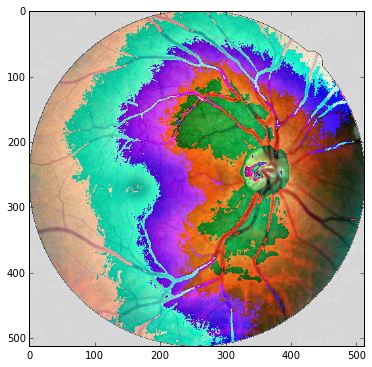

In [117]:
plt.imshow(a_batch[0][2].transpose((1,2,0)))

In [ ]:
def do_pred(generator, output_func):
    outputs = []
    for idx,batch in enumerate(generator):
        print("batch idx", idx)
        outputs.extend(output_func(batch[0].astype("float32"), batch[1].astype("float32")))
    return np.array(outputs)

def print_predictions(output_fh, pred_outputs, patient_ids):
    for i,patient_id in enumerate(patient_ids):
        for side in ['left', 'right']:
            if (side=='left'):
                pred = pred_outputs[i*2]
            else:
                pred = pred_outputs[i*2 + 1]
            output_fh.write(str(patient_id)+"_"+side+"\t"
                            +"\t".join([str(x) for x in pred])+"\n")

transfo_param_sets = [
    {'xyflip': xyflip,
     'horizontalflip': horizontalflip,
     'verticalflip': verticalflip}
    for xyflip in [False, True]
    for horizontalflip in [False, True]
    for verticalflip in [False, True]
]
            
for transfo_params in transfo_param_sets:
    transfo_string_summary = (
        "xyflip-"+str(transfo_params['xyflip'])
        +"_horizontalflip-"+str(transfo_params['horizontalflip'])
        +"_verticalflip-"+str(transfo_params['verticalflip']))
    if (os.path.exists(transfo_string_summary)==False):
        os.mkdir(transfo_string_summary)
    
    batch_generator = get_image_batch_generator(
        image_paths = valid_image_paths,
        batch_size=32,
        output_shape=(512,512),
        zmuv_mean=0.042,
        zmuv_std=0.204,
        **transfo_params)
    
    print("Doing deterministic predictions for "+transfo_string_summary)
    sys.stdout.flush()
    pred_outputs, chunk_orig = do_pred(generator=batch_generator,
                                       output_func=compute_output)
    output_file = transfo_string_summary+"/deterministic_preds.txt"
    output_fh = open(output_file,'w')
    print_predictions(output_fh=output_fh,
                      pred_outputs=pred_outputs,
                      patient_ids=valid_patient_ids)
    output_fh.close()
    for nondeterministic_run in range(100):
        print("nondet run",nondeterministic_run)
        sys.stdout.flush()
        pred_outputs, chunk_orig = do_pred(generator=batch_generator,
                                           output_func=compute_nondeterministic_output)
        output_file = (transfo_string_summary+
                       "/nondeterministic_preds_"
                       +str(nondeterministic_run)+".txt")
        output_fh = open(output_file,'w')
        print_predictions(output_fh=output_fh,
                          pred_outputs=pred_outputs,
                          patient_ids=valid_patient_ids)
        output_fh.close()

Doing deterministic predictions for xyflip-False_horizontalflip-False_verticalflip-False
('batch idx', 0)
('batch idx', 1)
('batch idx', 2)
('batch idx', 3)
('batch idx', 4)
('batch idx', 5)
('batch idx', 6)
('batch idx', 7)
('batch idx', 8)